# R notebook for histology and growth performance data analysis of soy-tolerant rainbow trout (Tissues: plasma and intestine, RBT Strains: commercial and select strain, Diets: FM and PM)

In [1]:
library(tidyverse)
library(ggpubr)

── Attaching core tidyverse packages ──────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


#### Read in the raw data

In [2]:
inthist <- read.csv('NathanCode//tidyhistintermediate.csv')
hist <- read.csv('NathanCode//tidyhist.csv')

#### Adjusting group labels

In [3]:
inthist <- inthist %>% mutate(Villi_Length = as.numeric(Villi.length),
                              Villi_Width = as.numeric(Villi.width)) %>% select(-c(Villi.length, Villi.width, X, X.1))
inthist$Group <- str_replace_all(inthist$Group, c("ARS" = 'Sel', "TL" = "Com"))
inthist$Group <- factor(inthist$Group, levels = c('Com FM', 'Com PM','Sel FM', 'Sel PM'))

#### Generate boxplots with statistical testing using global ANOVA and pairwise t-test for quantitative histology measures - villi length and weight

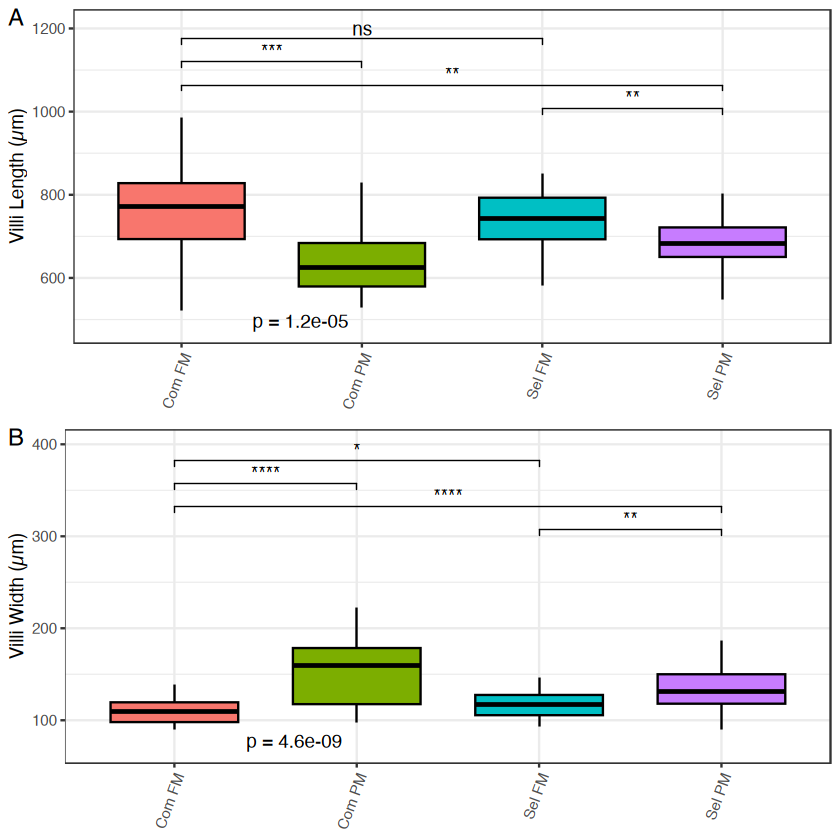

In [4]:
comp_list <- list(c('Sel FM', 'Sel PM'), c('Sel PM', 'Com FM'), c('Com FM', 'Com PM'), c('Sel FM', 'Com FM'))#, c('Sel PM', 'Com PM'), c('Sel FM', 'Com PM'))

P1 <- ggboxplot(inthist, x='Group', y='Villi_Length', fill='Group', outlier.shape = NA) + stat_compare_means(method='anova', label.y=480, label.x=1.5, label='p.format') + stat_compare_means(method='t.test', comparisons = comp_list, label='p.signif',p.adjust.methods='BH')  + theme_bw() + ylab('Villi Length (µm)') + ylim(480, 1210) + rotate_x_text(70) + theme(axis.title.x = element_blank())

P2 <- ggboxplot(inthist, x='Group', y='Villi_Width', fill='Group', outlier.shape = NA) + stat_compare_means(method='anova', label.y=70, label.x=1.5, label='p.format') + stat_compare_means(method='t.test', comparisons = comp_list, label='p.signif',p.adjust.methods='BH') + theme_bw() + ylab('Villi Width (µm)') + ylim(70, 400) + rotate_x_text(70) + theme(axis.title.x = element_blank())

P1_2 <- ggarrange(P1, P2, ncol=1, labels = "AUTO", common.legend=TRUE, legend='none')
P1_2

#### Generate barplots of ordinal histological scoring data - plot by median with range error-bars

Warning message in wilcox.test.default(c(1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, :
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(c(1, 1, 2, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, :
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(c(1, 1, 2, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, :
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(c(2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, :
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(c(1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 2, 1, :
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(c(1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 2, :
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(c(1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 2, :
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(c(1, 1, 2, 1, 1, 2, 1, 1, 2, 2, 1, 1, 1, :
“cannot compute exact p-value with ties”
Warning message 

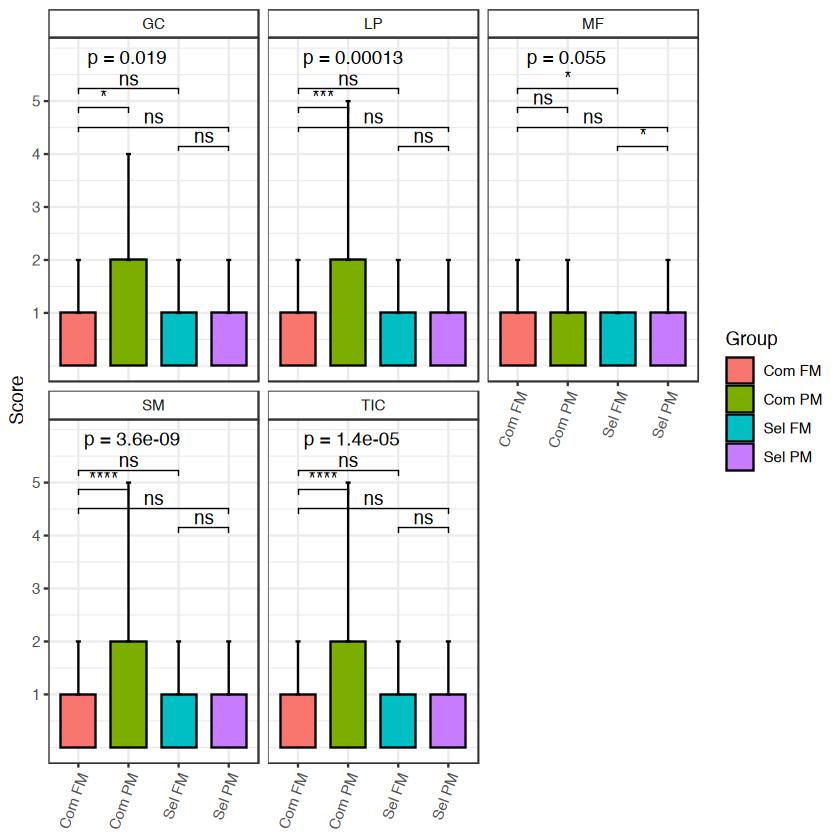

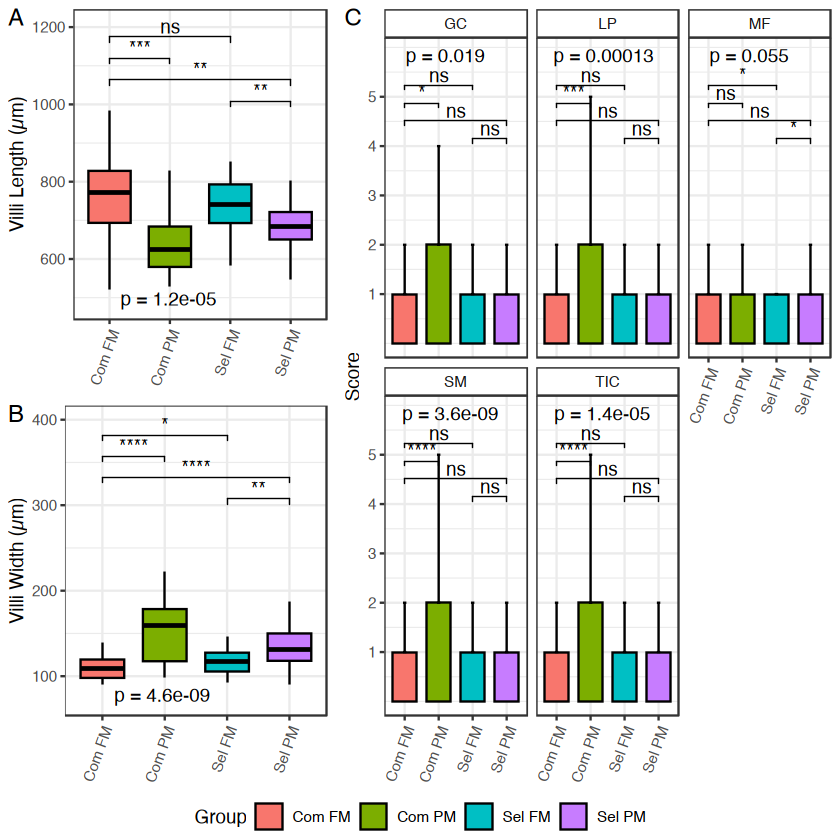

In [5]:
inthistlong <- inthist %>% pivot_longer(c( TIC, MF, GC, LP, SM), names_to='Metric', values_to='Score') %>% mutate(Score=as.numeric(Score))

P3 <- ggbarplot(inthistlong, x='Group', y='Score', fill='Group', facet.by = 'Metric', add='median_range', error.plot='upper_errorbar') + theme_bw() + stat_compare_means(method='kruskal', label.y=5.7, label.x=1.5, label='p.format') + stat_compare_means(comparisons = comp_list, label='p.signif', method='wilcox.test', exact=FALSE)  + rotate_x_text(70) + theme(axis.title.x = element_blank()) + theme(strip.background =element_rect(fill="white")) + scale_y_continuous(breaks=c(seq(1,5,1)), limits=c(0,5.9))
P3

histPlot <- ggarrange(P1_2, P3, ncol=2, widths = c(0.4, 0.6), labels=c('', 'C'), common.legend=TRUE, legend = 'bottom')
histPlot
#ggsave('HistPlot.png', scale=1, width=10, height=7)

#### Multivariate multiple correspondance analyis (MCA) and plotting

In [6]:
### MCA Plot
library(FactoMineR)
library(factoextra)

hist$Group[which(hist$Group == 'TL PM')] <- 'Com PM'
hist$Group[which(hist$Group == 'TL FM')] <- 'Com FM'
hist$Group[which(hist$Group == 'ARS FM')] <- 'Sel FM'
hist$Group[which(hist$Group == 'ARS PM')] <- 'Sel PM'

hist$Group <- factor(hist$Group, levels = c('Com FM', 'Com PM','Sel FM', 'Sel PM'))

hist$TIC <- as.factor(hist$TIC)
hist$MF <- as.factor(hist$MF)
hist$LP <- as.factor (hist$LP)
hist$GC <- as.factor(hist$GC)
hist$SM <- as.factor(hist$SM)

mca2 <- MCA(hist[,2:6])

grp <- hist$Group

P4 <- fviz_mca_ind(mca2, label = "quali.sup", habillage = grp, addEllipses = TRUE, repel=FALSE, ellipse.type = "norm", ellipse.level = 0.95, invisible="quali") + theme_bw() + theme(plot.title = element_blank(), legend.position = 'none') 

#P5 <- fviz_mca_var(mca2, label ='none') + theme_bw() + theme(plot.title = element_blank(),legend.position = 'none') 

FinalPlot <- ggarrange(histPlot, P4, ncol=1, labels=c('', 'D'), heights=c(0.75, 0.25))

ggsave('Figures/HistPlot.tiff', bg='white', width=6, height=7, unit='in', scale=1.3)           

Welcome! Want to learn more? See two factoextra-related books at https://goo.gl/ve3WBa

Warning message:
“ggrepel: 3 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


#### list the median and range for each ordinal variable, by strain diet group

In [7]:
hist %>% group_by(Group) %>% mutate_at(vars(-Group), as.numeric) %>% summarise_all(median, na.rm=TRUE)
hist %>% group_by(Group) %>% mutate_at(vars(-Group), as.numeric) %>% summarise_all(max, na.rm=TRUE)

Group,TIC,MF,GC,LP,SM
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Com FM,1,1,1,1,1
Com PM,2,1,2,2,2
Sel FM,1,1,1,1,1
Sel PM,1,1,1,1,1


Group,TIC,MF,GC,LP,SM
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Com FM,2,2,2,2,2
Com PM,4,2,3,4,4
Sel FM,2,1,2,2,2
Sel PM,2,2,2,2,2


## Growth Data - plotting and statistical testing

In [8]:
growthData <- read.csv('FishGrowth.csv')
colnames(growthData)
#growthData

[1] "Tank"          "Cross"         "IntialNumber"  "Morts"        
 [5] "FinalNumber"   "TotalIntialWt" "TotalFinalWt"  "TotalWtGain"  
 [9] "AvgIntialWt"   "AvgFinalWt"    "AvgWtGain"     "TotalFeed"    
[13] "AvgFeedFish"   "PercWtGain"    "PerBWGain"     "FCR"          
[17] "SGR"

In [9]:
growthData <- growthData %>% mutate(Survival = round((Morts/IntialNumber)*100,1), .after = FinalNumber)

In [10]:
growthData$Cross <- recode(growthData$Cross, 'TL-P' = "Com PM", 'TL-F' = 'Com FM', 'CX-AM-P' = 'Sel PM', 'CX-AM-F' = 'Sel FM')
growthData$Cross <- factor(growthData$Cross, levels = c('Com FM', 'Com PM', 'Sel FM', 'Sel PM'))


In [11]:
growthData %>% group_by(Cross) %>% summarise(mean(Survival), sd(Survival))

Cross,mean(Survival),sd(Survival)
<fct>,<dbl>,<dbl>
Com FM,0.8333333,1.443376
Com PM,8.8666667,4.461315
Sel FM,1.7666667,3.059956
Sel PM,2.6333333,2.702468


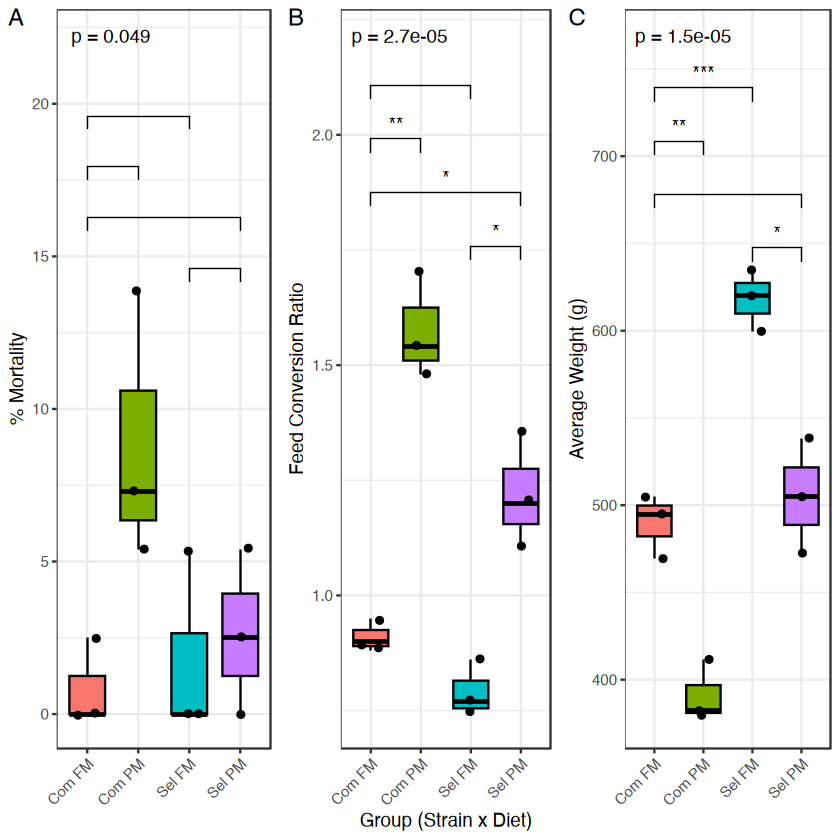

In [12]:
comp_list <- list(c('Sel FM', 'Sel PM'), c('Sel PM', 'Com FM'), c('Com FM', 'Com PM'), c('Sel FM', 'Com FM'))#, c('Sel PM', 'Com PM'), c('Sel FM', 'Com PM'))
FCR <- ggboxplot(growthData, x = 'Cross', y = 'FCR', add = c('jitter'), fill = 'Cross', ylab = 'Feed Conversion Ratio', xlab = 'Group (Strain x Diet)') + theme(legend.position = 'none') + stat_compare_means(method= "anova", paired=FALSE, label='p.format', label.y=2.2) + stat_compare_means(method= "t.test", paired=FALSE, comparisons = comp_list, label='p.signif', p.adjust.method='BH', hide.ns=TRUE) + rotate_x_text(90) + theme_bw() + rotate_x_text(45)
Surv <- ggboxplot(growthData, x = 'Cross', y = 'Survival', add = c('jitter'), fill = 'Cross', ylab = '% Mortality', xlab = '') + theme(legend.position = 'none') + stat_compare_means(method= "anova", paired=FALSE, label='p.format', label.y=22) + stat_compare_means(method= "t.test", paired=FALSE, comparisons = comp_list, label='p.signif', p.adjust.method='BH', hide.ns=TRUE) + theme_bw() + rotate_x_text(45)
WtGn <- ggboxplot(growthData, x = 'Cross', y = 'AvgFinalWt', add = c('jitter'), fill = 'Cross', ylab = 'Average Weight (g)', xlab = '') + theme(legend.position = 'none') + stat_compare_means(method= "anova", paired=FALSE, label='p.format', label.y=765) + stat_compare_means(method= "t.test", paired=FALSE, comparisons = comp_list, label='p.signif', p.adjust.method='BH', hide.ns=TRUE) + theme_bw() + rotate_x_text(45)

ggarrange(Surv, FCR, WtGn, common.legend = TRUE, legend='none', nrow=1, labels='AUTO') 
ggsave('Figures/GrowthPerformance.tiff', width=5.5, height=4.5, units='in', dpi=300)

### Run statistical tests for growth performance data

In [13]:
library(dplyr)
library(xtable)
library(ggplot2)
library(multcompView)

# Function to run ANOVA, Tukey's test, and extract significant group comparisons
run_anova_tukey <- function(data, response_var, group_var = "Cross") {
  # Run ANOVA
  anova_result <- aov(as.formula(paste(response_var, "~", group_var)), data = data)
  
  # Check if ANOVA is significant
  anova_summary <- summary(anova_result)
  p_value <- anova_summary[[1]]$`Pr(>F)`[1]
  
  # If significant, run Tukey's post hoc test
  if (p_value < 0.05) {
    tukey_result <- TukeyHSD(anova_result)
    tukey_summary <- tukey_result[[group_var]]
    
    # Extract significant group comparisons
    significant_comparisons <- tukey_summary[tukey_summary[, "p adj"] < 0.05, ]
    significant_groups <- rownames(significant_comparisons)
    
    # Create annotation for significant differences
    if (length(significant_groups) > 0) {
      comparisons <- gsub(" ", "", significant_groups)
      annotations <- paste0(response_var, ": ", comparisons, collapse = "; ")
    } else {
      annotations <- paste0(response_var, ": No significant differences")
    }
  } else {
    annotations <- paste0(response_var, ": No significant differences")
  }
  
  return(annotations)
}

# List of growth metrics to analyze
growth_metrics <- c("Survival", "AvgFinalWt", "AvgWtGain", "FCR", "SGR")

# Apply the function to each growth metric
annotations <- sapply(growth_metrics, run_anova_tukey, data = growthData)

# Print out annotations
print(annotations)

# Create the summary table
summary_df <- growthData %>%
  group_by(Cross) %>%
  summarise(across(c(Survival, AvgFinalWt, AvgWtGain, FCR, SGR), 
                   list(mean = ~ mean(.), sd = ~ sd(.)), 
                   .names = "{col}_{fn}"))

# Combine mean and SD into one column
formatted_summary <- summary_df %>%
  mutate(across(ends_with("_mean"), 
                .fns = ~ paste0(round(.x, 2), " ± ", round(get(sub("mean", "sd", cur_column())), 2)),
                .names = "{sub('_mean', '', col)}")) %>%
  select(Cross, Survival, AvgFinalWt, AvgWtGain, FCR, SGR)

# Convert to a LaTeX table
latex_table <- xtable(formatted_summary)

# Print the LaTeX code
print(latex_table, include.rownames = FALSE)

# Optionally, you could add annotations to the table or export them for use in figures

                                                                                                                     Survival 
                                                                                       "Survival: No significant differences" 
                                                                                                                   AvgFinalWt 
"AvgFinalWt: ComPM-ComFM; AvgFinalWt: SelFM-ComFM; AvgFinalWt: SelFM-ComPM; AvgFinalWt: SelPM-ComPM; AvgFinalWt: SelPM-SelFM" 
                                                                                                                    AvgWtGain 
                                                     "AvgWtGain: ComPM-ComFM; AvgWtGain: SelFM-ComPM; AvgWtGain: SelPM-SelFM" 
                                                                                                                          FCR 
                                   "FCR: ComPM-ComFM; FCR: SelPM-ComFM; FCR: SelFM-ComPM; FCR: SelPM-ComPM; FCR

In [14]:
annotations

Survival 
                                                                                       "Survival: No significant differences" 
                                                                                                                   AvgFinalWt 
"AvgFinalWt: ComPM-ComFM; AvgFinalWt: SelFM-ComFM; AvgFinalWt: SelFM-ComPM; AvgFinalWt: SelPM-ComPM; AvgFinalWt: SelPM-SelFM" 
                                                                                                                    AvgWtGain 
                                                     "AvgWtGain: ComPM-ComFM; AvgWtGain: SelFM-ComPM; AvgWtGain: SelPM-SelFM" 
                                                                                                                          FCR 
                                   "FCR: ComPM-ComFM; FCR: SelPM-ComFM; FCR: SelFM-ComPM; FCR: SelPM-ComPM; FCR: SelPM-SelFM" 
                                                                                                                          SGR 
                                                                                            "SGR: No significant differences"

In [15]:
summary(aov(Survival~Cross, data=growthData))

            Df Sum Sq Mean Sq F value Pr(>F)  
Cross        3 119.00   39.67   4.105 0.0489 *
Residuals    8  77.31    9.66                 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

In [16]:
TukeyHSD(aov(Survival~Cross, data=growthData))

  Tukey multiple comparisons of means
    95% family-wise confidence level

Fit: aov(formula = Survival ~ Cross, data = growthData)

$Cross
                    diff          lwr       upr     p adj
Com PM-Com FM  8.0333333  -0.09472701 16.161394 0.0526972
Sel FM-Com FM  0.9333333  -7.19472701  9.061394 0.9818177
Sel PM-Com FM  1.8000000  -6.32806034  9.928060 0.8907238
Sel FM-Com PM -7.1000000 -15.22806034  1.028060 0.0885644
Sel PM-Com PM -6.2333333 -14.36139367  1.894727 0.1429174
Sel PM-Sel FM  0.8666667  -7.26139367  8.994727 0.9853056
